# Severity Classification of Alzheimer's Disease Using MRI Images
## Jason Lu, Juan Marcucci, Dan Rossetti
---
---

# NOTEBOOK 4 - Binary Classification CNN and Pretrained Models

Notebook Summary:

This notebook seeks to understand if creating binary classifcaiton versions of some of the models in Notebooks 2 and 3 on only the No Dementia and Very Mild Dementia classes will have a positive impact on the models' ability to predict those two classes.  

The purpose of this Notebook as it related to the problem statement is to understand if a binary classifcation model increase would be better suited to the early detection of dementia and possibly Alzheimer's.

---
---

#  WARNING:  NOTEBOOK MUST BE RUN IN GOOGLE COLAB

Due to the computational demands of the convolutional neural networks used in this model requiring GPUs, this project was created entirely on Google Colab.

Further, the data are imported by cloning the Github repo where all of the project materials are stored into Google Colab so that the code can be run anywhere with the relative paths in this notebook.  With that, these relative paths will not work outside of Google Colab.

---
---

# 0 - Imports

In [ ]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Every method known to set random seeds (from the following sources):
# Help with this import:  https://www.tensorflow.org/tutorials/quickstart/advanced
import random
import tensorflow as tf
seed = 42
# Source provided by Eric Bayless for help with this:  
#  https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Help with code below from:  https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(seed)

# TensorFlow imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# Pretrained model imports:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


# Evaluation imports
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

# 1 - Connect to Github, Read Data
These are the same steps as perfomred in all other notebooks to gather the data.

As they have been previously established and commented, they are combined into a single cell for space and notebook readability.

In [ ]:
# Clear out the directory in case the code is re-run top to bottom.
!rm -r ga_project_4/

# Inspiration to do this from:  https://stackoverflow.com/questions/65386157/importing-images-from-github-to-colab
# Code help from:  https://neptune.ai/blog/google-colab-dealing-with-files
!git clone https://github.com/drossDS/ga_project_4.git

# Help with this code to cd into folders from:  
#  https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter
%cd ga_project_4/
%cd data/

# Unzip data
!unzip -q archive_binary.zip

rm: cannot remove 'ga_project_4/': No such file or directory
Cloning into 'ga_project_4'...
remote: Enumerating objects: 6494, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 6494 (delta 25), reused 50 (delta 18), pack-reused 6424
Receiving objects: 100% (6494/6494), 157.24 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/ga_project_4
/content/ga_project_4/data


# 2 - Create Training and Validation Datasets, Import Testing Dataset

This is virtually the same code as in all other notebooks except that it has been adapted for a binary classifcaiton model.

It should further be noted that in order for the code below to work, an entirely separate zip file from that used in all other notebooks had to be created with only the No Dementia and Very Mild Dementia images.  There does not appear to be a way to have the 'image_dataset_from_directory' function run in such a way that the classes (generated from the subfolders in the specified directory) can be selected individually.

In [ ]:
# Create the training dataset using a 90/10 train/validation split
train_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'training',
    label_mode = 'binary',
    
)

val_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/train',
    image_size = (208, 176),
    batch_size = 32,
    seed = 42,
    validation_split = 0.20,
    subset = 'validation', 
    label_mode = 'binary',
)

'''
The testing dataset will be imported in a similar manner, but
does not need to be batched or split.  So some of the arguments input
previously will not need to be called
'''
test_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/test',
    image_size = (208, 176),
    label_mode = 'binary',
    seed = 42,
    shuffle = False
)

Found 4352 files belonging to 2 classes.
Using 3482 files for training.
Found 4352 files belonging to 2 classes.
Using 870 files for validation.
Found 1088 files belonging to 2 classes.


# 3 - Modeling
This section will examine three models from Notebooks 2 & 3 specifically the:
* Initial CNN Model
* Optimized CNN Model
* InceptionV3 Model

While nearly identical to the code in the other notebooks, they are adapted for binary classification as required.

## Evaluation Metrics
When comapring binary models, the primary evaluation metric that will be used is the accuracy.  Aiming for a model with the best possible accuracy is an all-encompassing strategy to target model optimization and for model selection.

Clinically, the recall (sensitivity) for each class will also need to be examined, particularly for the Very Mild Dementia class, given that this portion of the model is focused on early detection of Alzheimers.  Recall will provide a good indication of how much of the Very Mild Dementia class is being properly identified.  It is preferable to have a model which would favor false positives so that further work could be done by clinicians to more confidently diagnose Alheimer's dementia.

Lastly, recall will be the primary metric to evaluate the performance of this binary classification model against the multi-class classification models as the recall metric is tailored to the proper identification of a particular class regardless of how many other classes are present.  This is required to understand if a binary classification model would do a better job at identifying very mild dementia than the multi-class models.

## 3.1 - Modeling Functions
These functions are nearly identical to those used in Notebooks 2 & 3 but adapated for the outputs of a binary classification model.

In [ ]:
'''
*** THIS FUNCTION IS REQUIRED TO COMPARE PREDICTED CLASSES TO TRUE CLASSES ***

Here a function is being defined which will extract and format the target data from the 
BatchDataset and then format it into an array of numbers that provide the class numbers.

It will optionally convert this to a pandas series for pandas operations (like .value_counts()).
'''

def target_extractor(data_array, series=False):

  # Source for help with the following line of code to extract classes:
  #  https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
  '''
  The list comprehension produces a list as in the other notebooks.
  
  For the binary classification model, this function is rewritten to handing the
  differing format that is output for the targets.  Argmax cannot be used and 
  instead, two concatenation functions must be used to fully flatten the nested
  prediction arrays into a single array that can be input into metrics functions.
  '''  
  y = pd.Series(np.concatenate(np.concatenate([y for x, y in data_array])))

  return y

In [ ]:
'''
Create a funciton which will plot the final and best training and validation accuracies on a given model.
'''

def acc_printer(model):
  # Print the training and testing accuracies
  print(f"Final Model Accuracy on Training Data:  {model.history['acc'][-1]}")
  print(f"Final Model Accuracy on Validation Data:  {model.history['val_acc'][-1]}")

  print(f"Best Model Accuracy on Training Data:  {model.history['acc'][np.argmax(model.history['acc'])]}")
  print(f"Best Model Accuracy on Validation Data:  {model.history['val_acc'][np.argmax(model.history['val_acc'])]}")

In [ ]:
'''
Create a fucntion which plots confusion matrix and gives accuracy stats
'''

def results_plotter(input_model,
                    result_variable,
                    fig_name,
                    report = False):
  # Print the training and testing accuracies
  acc_printer(result_variable)

  # Get the model predictions
  preds = input_model.predict(test_ds, verbose = 0)

  # Convert the model predicitons into an array with class values
  preds_arr = np.round(preds)
  print(preds_arr.shape)
  preds_arr

  # Create a y_test array from test_ds that can be compared to the predictions
  y_test = target_extractor(test_ds)
  print(y_test.shape)
  y_test

  ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)
  plt.title(f'{fig_name}', fontsize = 20)
  plt.xlabel('Predicted Label', size = 16)
  plt.ylabel('True Label', size = 16)
  # Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
  plt.xticks([0,1], ['none', 'vmld'])
  plt.yticks([0,1], ['none', 'vmld']);
  print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')
  plt.savefig(f'/content/ga_project_4/conf_matrix_{fig_name}.png')
  plt.show();

  if report == True:
    print(classification_report(y_test, preds_arr, target_names = ["none", 'very_mild']))

## 3.2 - Establish Null Model

In [ ]:
# Find the value counts of each class using the function created

'''
The code below was written in a way which does not work on binary models.
target_extractor(train_ds, series=True).value_counts(normalize = True)
'''
# A double concatenate is required to pull the values out
pd.Series(np.concatenate(np.concatenate([y for x, y in test_ds]))).value_counts(normalize = True)

0.0    0.588235
1.0    0.411765
dtype: float64

#### OBSERVATIONS:
* The classes are represented as numbers representing the folders in their (alphabetical) order:
  * Class 0 is No Dementia
  * Class 1 is Very Mild Dementia
* The classes are split at nearly 60/40 No Dementia/Very Mild Dementia.  The null model would then assume that all images are brains with no dementia and have an accuracy of approximately 58.8%
* Successful models below will need to exceed this accuracy


## 3.3 - Run Initial Convolutional Neural Network Model
Same model architecture as from Notebook 2.

In [ ]:
# Instantiate the sequential model_bin
model_bin = Sequential()

# Input later is needed for the model_bin summary
model_bin.add(layers.Input(shape=(208, 176, 3)))

# Rescaling layer - which basically divides everything by 255 to get
#  the values between 0 and 1
model_bin.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer
model_bin.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model_bin.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional and pooling layer
model_bin.add(Conv2D(64, (3,3), activation = 'relu')) # 'kernel' and 'filter' are synonymous
model_bin.add(MaxPooling2D(pool_size=(2,2)))

# The above layers need to be flattened to a single dimension to be fed into
#  the dense layers below.
model_bin.add(Flatten())

# First dense layer
model_bin.add(Dense(64, activation='relu'))

# Output
model_bin.add(Dense(1, activation = 'sigmoid'))

# Compile it
model_bin.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

# Fit it
res_model_bin = model_bin.fit(train_ds,
               epochs = 5,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1)

Epoch 1/5
109/109 [==============================] - 20s 66ms/step - loss: 0.6658 - acc: 0.6160 - val_loss: 0.5478 - val_acc: 0.7149
Epoch 2/5
109/109 [==============================] - 6s 53ms/step - loss: 0.4675 - acc: 0.7771 - val_loss: 0.3284 - val_acc: 0.8747
Epoch 3/5
109/109 [==============================] - 6s 58ms/step - loss: 0.2473 - acc: 0.9009 - val_loss: 0.1534 - val_acc: 0.9448
Epoch 4/5
109/109 [==============================] - 6s 52ms/step - loss: 0.1025 - acc: 0.9647 - val_loss: 0.0875 - val_acc: 0.9644
Epoch 5/5
109/109 [==============================] - 6s 57ms/step - loss: 0.0379 - acc: 0.9905 - val_loss: 0.0392 - val_acc: 0.9931


Final Model Accuracy on Training Data:  0.9905226826667786
Final Model Accuracy on Validation Data:  0.9931034445762634
Best Model Accuracy on Training Data:  0.9905226826667786
Best Model Accuracy on Validation Data:  0.9931034445762634
(1088, 1)
(1088,)
Model Accuracy on Test Data: 0.6397058823529411 



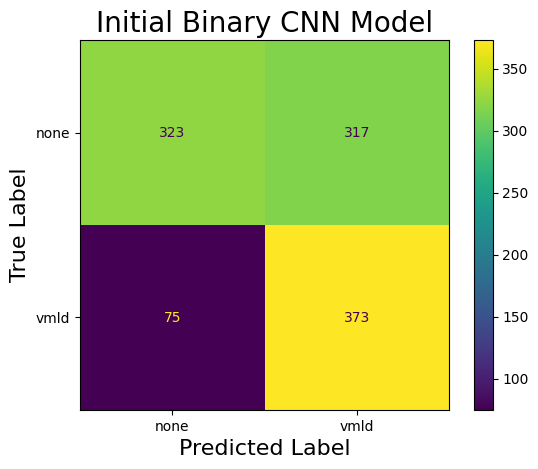

              precision    recall  f1-score   support

        none       0.81      0.50      0.62       640
   very_mild       0.54      0.83      0.66       448

    accuracy                           0.64      1088
   macro avg       0.68      0.67      0.64      1088
weighted avg       0.70      0.64      0.64      1088



In [ ]:
# Print the results
results_plotter(model_bin, res_model_bin, fig_name = 'Initial Binary CNN Model', report = True)

#### OBSERVATIONS:
* The overall model accuracy on the test data is much lower than on the training and validation data at approximately 64% (given that the neural network results vary from run to run)
* From the confusion matrix, the model appears to be confusing some of the no dementia and very mild dementia images
* The recall (sensitivity) for the Very Mild Dementia class is higher than that of the No Dementia.  This is beneficial from the standpoint of detecting a disease where a higher percentage of false positives is better than a higher percentage of false negatives.
* As comapred to the multiclass classification model in Notebook 2, this binary model appears to have the same recall value at 83%

# 3.4 Optimized CNN
Same model architecture as from Notebook 2.

In [ ]:
# Instantiate the sequential model_a_bin
model_a_bin = Sequential()

# Early stopping
early_stopping = EarlyStopping(patience=10)

# Input layer and Rescaling
model_a_bin.add(layers.Input(shape=(208, 176, 3)))
model_a_bin.add(layers.Rescaling(1./255)) 

# Convolutional and pooling layer - 1
model_a_bin.add(Conv2D(64, (3,3),
                 padding='same', 
                 activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))

# Batch Normalization layer
model_a_bin.add(BatchNormalization())

# Convolutional and pooling layer
model_a_bin.add(Conv2D(64, (3,3), 
                 padding='same',
                 activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))
model_a_bin.add(BatchNormalization())

# Convolutional and pooling layer
model_a_bin.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))
model_a_bin.add(BatchNormalization())

# Convlutional and pooling layers 4 - 7
model_a_bin.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))

model_a_bin.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))

model_a_bin.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))

model_a_bin.add(Conv2D(64, (3,3), padding='same', activation = 'relu')) 
model_a_bin.add(MaxPooling2D(pool_size=(2,2)))

# Flatten layer
model_a_bin.add(Flatten())

# Fully connected layer
model_a_bin.add(Dense(64, activation='relu'))

# Batch normalization before output layer
model_a_bin.add(BatchNormalization())

# Output layer
model_a_bin.add(Dense(1, activation = 'sigmoid'))

# Compile model_a_bin
model_a_bin.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

# Fit model_a_bin
res_model_a_bin = model_a_bin.fit(train_ds,
               epochs = 20,
               batch_size = 64,
               validation_data = val_ds,
               verbose = 1,
               callbacks=[early_stopping])

Epoch 1/20
109/109 [==============================] - 16s 78ms/step - loss: 0.5669 - acc: 0.7028 - val_loss: 0.6774 - val_acc: 0.5563
Epoch 2/20
109/109 [==============================] - 8s 72ms/step - loss: 0.4028 - acc: 0.8090 - val_loss: 0.7961 - val_acc: 0.5655
Epoch 3/20
109/109 [==============================] - 7s 65ms/step - loss: 0.2592 - acc: 0.8978 - val_loss: 0.4644 - val_acc: 0.7943
Epoch 4/20
109/109 [==============================] - 8s 71ms/step - loss: 0.1567 - acc: 0.9385 - val_loss: 1.5436 - val_acc: 0.5632
Epoch 5/20
109/109 [==============================] - 8s 69ms/step - loss: 0.0814 - acc: 0.9719 - val_loss: 0.6012 - val_acc: 0.7621
Epoch 6/20
109/109 [==============================] - 7s 65ms/step - loss: 0.0562 - acc: 0.9825 - val_loss: 2.3659 - val_acc: 0.5736
Epoch 7/20
109/109 [==============================] - 8s 69ms/step - loss: 0.0574 - acc: 0.9787 - val_loss: 0.9452 - val_acc: 0.7253
Epoch 8/20
109/109 [==============================] - 8s 72ms/step -

Final Model Accuracy on Training Data:  0.9997128248214722
Final Model Accuracy on Validation Data:  0.9977011680603027
Best Model Accuracy on Training Data:  0.9997128248214722
Best Model Accuracy on Validation Data:  0.9977011680603027
(1088, 1)
(1088,)
Model Accuracy on Test Data: 0.8115808823529411 



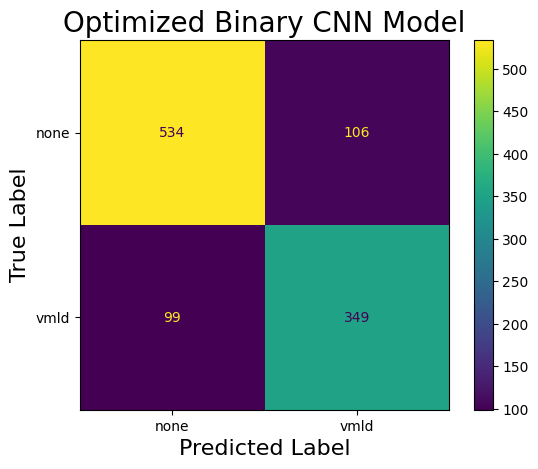

              precision    recall  f1-score   support

        none       0.84      0.83      0.84       640
   very_mild       0.77      0.78      0.77       448

    accuracy                           0.81      1088
   macro avg       0.81      0.81      0.81      1088
weighted avg       0.81      0.81      0.81      1088



In [ ]:
# Print the results
results_plotter(model_a_bin, res_model_a_bin, fig_name = 'Optimized Binary CNN Model', report = True)

#### OBSERVATIONS
* The optimized model appears to have better overall performance than the previous model with an accuracy of about 81%
* This model appears to confuse a smaller number of images as compared to the previous model
* Likewise, precision and recall values have increased, and the recall for the Very Mild Dementia class now slightly lower than that of the No Dementia class
* As comapred to the multiclass classification model in Notebook 2, this binary model appears to have a much better recall value for the Very Mild Dementia class at 78% compared to 29% for the multi-class model

## 3.5 - Pretrainaed Model - Inception V3
Same model architecture as from Notebook 3.

In [ ]:
# The following sources were used to implement this code:
#  https://keras.io/api/applications/inceptionv3/
#  https://cloud.google.com/tpu/docs/inception-v3-advanced

# Early stopping
early_stopping = EarlyStopping(patience=4)

# Function to resize and rescale images
def resize_and_rescale(image, label):
    image = tf.image.resize(image, [299, 299])
    image = preprocess_input(image) 
    return image, label

# Create new datasets for InceptionV3 model
train_ds_inception = train_ds.map(resize_and_rescale)
val_ds_inception = val_ds.map(resize_and_rescale)
test_ds_inception = test_ds.map(resize_and_rescale)

# Load InceptionV3 model
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# freeze the layers
for layer in inception.layers:
    layer.trainable = False

# input layer
inputs = layers.Input(shape=(299, 299, 3))

# pre-process for InceptionV3
x = preprocess_input(inputs) 

x = inception(x, training=False)

x = Flatten()(x) 

x = Dense(64, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.2)(x)

outputs = Dense(1, activation = 'sigmoid')(x)

# Assemble the model
model_inception_bin = Model(inputs=inputs, outputs=outputs)

# Compile the model
model_inception_bin.compile(loss='bce', optimizer='adam', metrics=['acc'])

# Fit the model to the data
res_cnn_inception_bin = model_inception_bin.fit(train_ds_inception,
                    epochs=20,
                    batch_size=16,
                    validation_data=val_ds_inception,
                    verbose=1,
                    callbacks=[early_stopping])

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/20
109/109 [==============================] - 34s 223ms/step - loss: 0.6085 - acc: 0.6841 - val_loss: 0.7027 - val_acc: 0.6345
Epoch 2/20
109/109 [==============================] - 19s 174ms/step - loss: 0.4115 - acc: 0.8142 - val_loss: 0.4537 - val_acc: 0.7667
Epoch 3/20
109/109 [==============================] - 21s 189ms/step - loss: 0.2583 - acc: 0.8978 - val_loss: 0.2495 - val_acc: 0.9023
Epoch 4/20
109/109 [==============================] - 19s 172ms/step - loss: 0.1607 - acc: 0.9434 - val_loss: 0.3553 - val_acc: 0.8345
Epoch 5/20
109/109 [==============================] - 21s 188ms/step - loss: 0.1071 - acc: 0.9670 - val_loss: 0.1511 - val_acc: 0.9448
Epoch 6/20
109/109 [==============================] - 19s 171ms/step - loss: 0.0870 - acc: 0.9733 - val_loss: 0.1174 - val_acc: 0.9598
Epoch 7/20
109/109 [==============================] - 20s 180ms/step - loss: 0.0572 - acc: 0.9897 - val_loss: 0.1071 - val_ac

Final Model Accuracy on Training Data:  0.9942561984062195
Final Model Accuracy on Validation Data:  0.9390804767608643
Best Model Accuracy on Training Data:  0.9942561984062195
Best Model Accuracy on Validation Data:  0.9666666388511658
34/34 [==============================] - 6s 137ms/step
(1088,)
(1088,)


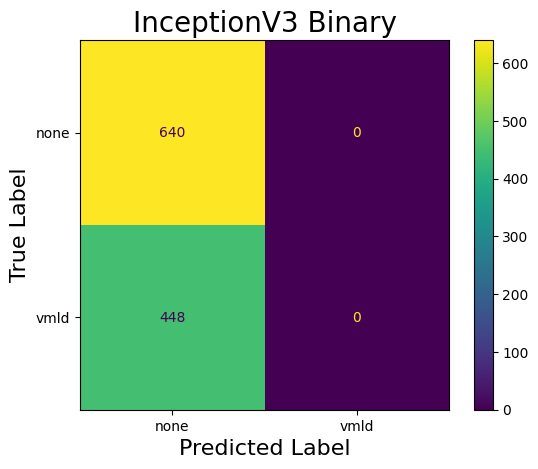

Model Accuracy on Test Data: 0.5882352941176471 

Model Roc Auc on Test Data: 0.8509277343749999 

              precision    recall  f1-score   support

        none       0.59      1.00      0.74       640
   very_mild       0.00      0.00      0.00       448

    accuracy                           0.59      1088
   macro avg       0.29      0.50      0.37      1088
weighted avg       0.35      0.59      0.44      1088



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Print the training and testing accuracies
acc_printer(res_cnn_inception_bin)
# Get the model predictions
preds = model_inception_bin.predict(test_ds_inception)

# Convert the model predictions into an array with class values
preds_arr = np.argmax(preds, axis = 1)
print(preds_arr.shape)
preds_arr
# Create a y_test array from test_ds that can be compared to the predictions
y_test = target_extractor(test_ds_inception)
print(y_test.shape)
y_test

ConfusionMatrixDisplay.from_predictions(y_test, preds_arr)
plt.title(f'InceptionV3 Binary', fontsize = 20)
plt.xlabel('Predicted Label', size = 16)
plt.ylabel('True Label', size = 16)
# Help relabeling the axes from:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
plt.xticks([0,1], ['none', 'vmld'])
plt.yticks([0,1], ['none', 'vmld']);
plt.savefig(f'/content/ga_project_4/conf_matrix_inceptionV3_bin.png')
plt.show();

print(f'Model Accuracy on Test Data: {accuracy_score(y_test, preds_arr)} \n')
print(f'Model Roc Auc on Test Data: {roc_auc_score(y_test, preds, multi_class="ovr")} \n')

print(classification_report(y_test, preds_arr, target_names = ["none", 'very_mild']))

#### OBSERVATIONS
* From the confusion matrix, it can be see that the incpetion model is simply acting as the null model and is incapable of making an accuracte (or any) prediction for Very Mild Dementia
  * With this, a discussion of accuracy and recall would be moot given that the model is not attempting to make classifcation for Very Mild Dementia.

# 4 - Binary Modeling Conclusions
Overall the results are mixed depending on which metric is being examined and which model is being run.
* The binary initial CNN model performed at 64% accuracy compared to 57% accuracy for the multt-class model.  However the recall for very mild dementia was comparable to the multiclass model at 83%
* The binary optimized CNN model perfomred better at 81% accuracy compared to 52% for the multi-class model.  This was also the best performing binary classification model.  Additionally, the recall was higher at 78% versus 29% for the multi-class
* The accuracy of the binary InceptionV3 model is identical to that of the null model at 59% given that the model trained itself to always choose the No Dementia class.  From an accuracy standpoint, this is slightly better than the mutli-class InceptionV3 model which had an accuracy of 71%